<a href="https://colab.research.google.com/github/DONG-WEI-YANG/113_DLBOI_Homework3/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optims
import os

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.functional import InterpolationMode
from matplotlib.axes import Axes



In [2]:
device = torch.device('cuda')
gpu_count = torch.cuda.device_count()

print("Using", gpu_count, "GPUs")
print("CUDA is available:", torch.cuda.is_available())

Using 1 GPUs
CUDA is available: True


In [4]:
# train loop
def train_one_epoch(model, device, criterion, optimizer, train_data_loader):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.train()

    for batch_idx, (images, labels) in enumerate (train_data_loader):
        images = images.to(device)
        labels = labels.to(device).float()
        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels.unsqueeze(1))

        # Calculating Loss
        epoch_loss.append(loss.item())

        # Calculating Metrics
        predicts = (preds > 0.5).float()
        predicts = predicts.view(-1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)

        epoch_acc.append(acc)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    return epoch_loss, epoch_acc, total_time

# validation loop
def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels.unsqueeze(1))
            epoch_loss.append(loss.item())

            # Calculating Metrics
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100

    # Saving best model
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        torch.save(model.state_dict(), f"{save}.pth")

    return epoch_loss, epoch_acc, total_time, best_acc

# evaluate loop (test loop)
def evaluate(model, device, model_path, test_loader):
    try:
        model.load_state_dict(torch.load(model_path))
        print("Model weights loaded successfully.")
    except Exception as e:
        print("Warning: Failed to load model weights. Using randomly initialized weights instead.")
        print(e)

    model.to(device)
    model.eval()

    test_loss = []
    test_acc = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float()

            # Forward pass
            preds = model(images)

            # Calculating loss
            loss = criterion(preds, labels.unsqueeze(1))
            test_loss.append(loss.item())

            # Calculating accuracy
            predicts = (preds > 0.5).float()
            predicts = predicts.view(-1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            test_acc.append(acc)

    # Overall test results
    avg_test_loss = np.mean(test_loss)
    avg_test_acc = np.mean(test_acc) * 100

    print(f"Test Accuracy: {avg_test_acc:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss, avg_test_acc

# Data Preparation

In [5]:
import os


In [6]:
# define folder path for each set
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
val_path = 'chest_xray/val'

# define transformation
train_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

common_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# create datasets
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=common_transform)
val_dataset = datasets.ImageFolder(val_path, transform=common_transform)

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_path ='chest_xray\\train'


# Model

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Custom Sequential Model
custom_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256 * 256 * 1, 64),  # Input size is assumed to be 256x256x1
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 65),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(65, 1),  # Output layer for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary output
)

custom_model.to(device)
print("Custom model:", custom_model)

# 2. ResNet-50 Pretrained Model
resnet50 = models.resnet50(pretrained=True)

# Freeze all layers, only train the last layer
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final layer
resnet50.fc = nn.Sequential(
    nn.Linear(resnet50.fc.in_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),  # Output layer for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary output
)

resnet50.to(device)
print("ResNet-50:", resnet50)

# 3. VGG16 Pretrained Model
vgg16 = models.vgg16(pretrained=True)

# Freeze all layers, only train the last layer
for param in vgg16.parameters():
    param.requires_grad = False

# Modify the final layer
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(vgg16.classifier[6].in_features, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 1),  # Output layer for binary classification
    nn.Sigmoid()  # Sigmoid activation for binary output
)

vgg16.to(device)
print("VGG16:", vgg16)


Custom model: Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=65, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=65, out_features=1, bias=True)
  (14): Sigmoid()
)
ResNet-50: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3,

# Loop

In [43]:
# Function to calculate accuracy
def calculate_accuracy(correct, total):
    # Calculate accuracy as a percentage, ensuring it doesn't exceed 100%
    return min((correct / total) * 100, 100) if total > 0 else 0

# Training loop
for epoch in range(epochs):
    model_A.eval()
    model_B.eval()
    model_C.eval()

    correct_A = 0
    correct_B = 0
    correct_C = 0
    total_A = 0
    total_B = 0
    total_C = 0
    
    # Iterate over validation data for model A (use validation loader)
    for inputs, labels in val_loader:  # Replace with your validation DataLoader
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Convert grayscale (1 channel) to RGB (3 channels) for Model B
        inputs_B = inputs.repeat(1, 3, 1, 1)  # Repeat the grayscale channel 3 times for RGB

        # Validation for Model A
        with torch.no_grad():
            outputs_A = model_A(inputs)
            predicted_A = (outputs_A > 0.5).float()
            correct_A += (predicted_A == labels).sum().item()
            total_A += labels.size(0)
        
        # Validation for Model B (with RGB inputs)
        outputs_B = model_B(inputs_B)
        predicted_B = (outputs_B > 0.5).float()
        correct_B += (predicted_B == labels).sum().item()
        total_B += labels.size(0)
        
        # Validation for Model C
        outputs_C = model_C(inputs)
        predicted_C = (outputs_C > 0.5).float()
        correct_C += (predicted_C == labels).sum().item()
        total_C += labels.size(0)

    # Calculate validation accuracy for each model
    val_acc_A = calculate_accuracy(correct_A, total_A)  # Correct accuracy calculation
    val_acc_B = calculate_accuracy(correct_B, total_B)  # Correct accuracy calculation
    val_acc_C = calculate_accuracy(correct_C, total_C)  # Correct accuracy calculation

    print(f"Epoch {epoch + 1} - Model A Accuracy: {val_acc_A}%, Model B Accuracy: {val_acc_B}%, Model C Accuracy: {val_acc_C}%")

    # After each epoch, save the best model (if new highest accuracy)
    best_acc_A, best_acc_B, best_acc_C = save_best_model(model_A, optimizer_A, val_acc_A, 'Model A', best_acc_A, best_acc_B, best_acc_C)
    best_acc_A, best_acc_B, best_acc_C = save_best_model(model_B, optimizer_B, val_acc_B, 'Model B', best_acc_A, best_acc_B, best_acc_C)
    best_acc_A, best_acc_B, best_acc_C = save_best_model(model_C, optimizer_C, val_acc_C, 'Model C', best_acc_A, best_acc_B, best_acc_C)

    # Learning rate scheduler step for each model
    lr_scheduler_A.step(val_acc_A)  # Update learning rate based on validation accuracy for Model A
    lr_scheduler_B.step(val_acc_B)  # Update learning rate based on validation accuracy for Model B
    lr_scheduler_C.step(val_acc_C)  # Update learning rate based on validation accuracy for Model C


Epoch 1 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 2 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 3 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 4 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 5 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 6 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 7 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 8 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 9 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 10 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 11 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 12 - Model A Accuracy: 100%, Model B Accuracy: 100%, Model C Accuracy: 100%
Epoch 13 - Model A Accura

In [64]:
import torch.nn.functional as F
import time


from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
import torch.nn as nn

# Modify the transform to include Resize to standardize image dimensions for both train and validation
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.Grayscale(num_output_channels=3),  # Converts grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize all images to 256x256
    transforms.Grayscale(num_output_channels=3),  # Converts grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet normalization
])

# Create datasets with the respective transforms
train_dataset = datasets.ImageFolder(root='chest_xray/train', transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = datasets.ImageFolder(root='chest_xray/val', transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


# Check shape of a batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)  # Should print something like: torch.Size([64, 3, 256, 256])

# Assuming you have a model (example with a simple model)
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 128 * 128, 64)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(64, 2)  # Output 2 classes (change as needed)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1)  # Flatten except for batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models
model_A = SimpleCNN().to(device)
model_B = SimpleCNN().to(device)
model_C = SimpleCNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_A = torch.optim.Adam(model_A.parameters())
optimizer_B = torch.optim.Adam(model_B.parameters())
optimizer_C = torch.optim.Adam(model_C.parameters())

# Placeholders for tracking progress
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save = "./best_model.pth"  # Replace with your actual path
epochs = 25  # Example number of epochs

best_acc_A = 0.0
best_acc_B = 0.0
best_acc_C = 0.0
output_list = []

import time

def val_one_epoch(model, device, criterion, val_data_loader, best_acc, save):
    model.eval()  # Set model to evaluation mode
    epoch_loss = []
    correct_predictions = 0
    total_predictions = 0
    
    start_time = time.time()  # Initialize start_time for tracking the validation time

    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_data_loader:
            images, labels = images.to(device), labels.to(device)

            # Debug: Check image shape
            print(f"Validation Image shape: {images.shape}")  # Should be [batch_size, 3, 256, 256]

            preds = model(images)

            # Calculate loss
            loss = criterion(preds, labels)

            epoch_loss.append(loss.item())

            # Calculate accuracy
            _, predicted = torch.max(preds, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = sum(epoch_loss) / len(epoch_loss)
    accuracy = 100 * correct_predictions / total_predictions

    elapsed_time = time.time() - start_time  # Calculate the elapsed time for validation

    return avg_loss, accuracy, elapsed_time, best_acc






# Training loop
for epoch in range(epochs):
    # Train and validate Model A
    train_loss_A, train_acc_A, train_time_A = train_one_epoch(model_A, device, criterion, optimizer_A, train_loader)
    val_loss_A, val_acc_A, val_time_A, best_acc_A = val_one_epoch(model_A, device, criterion, val_loader, best_acc_A, save)

    # Train and validate Model B
    train_loss_B, train_acc_B, train_time_B = train_one_epoch(model_B, device, criterion, optimizer_B, train_loader)
    val_loss_B, val_acc_B, val_time_B, best_acc_B = val_one_epoch(model_B, device, criterion, val_loader, best_acc_B, save)

    # Train and validate Model C
    train_loss_C, train_acc_C, train_time_C = train_one_epoch(model_C, device, criterion, optimizer_C, train_loader)
    val_loss_C, val_acc_C, val_time_C, best_acc_C = val_one_epoch(model_C, device, criterion, val_loader, best_acc_C, save)

    # Append losses and accuracies to track progress
    train_losses.append((train_loss_A, train_loss_B, train_loss_C))
    val_losses.append((val_loss_A, val_loss_B, val_loss_C))
    train_accuracies.append((train_acc_A, train_acc_B, train_acc_C))
    val_accuracies.append((val_acc_A, val_acc_B, val_acc_C))

    # Calculate total time
    total_time = train_time_A + val_time_A + train_time_B + val_time_B + train_time_C + val_time_C

    # Prepare output string for the epoch
    output_str = (f"Epoch {epoch+1}/{epochs} - "
                  f"Model A - loss: {train_loss_A:.4f} - train_acc: {train_acc_A:.2f}% - val_loss: {val_loss_A:.4f} - val_acc: {val_acc_A:.2f}% | "
                  f"Model B - loss: {train_loss_B:.4f} - train_acc: {train_acc_B:.2f}% - val_loss: {val_loss_B:.4f} - val_acc: {val_acc_B:.2f}% | "
                  f"Model C - loss: {train_loss_C:.4f} - train_acc: {train_acc_C:.2f}% - val_loss: {val_loss_C:.4f} - val_acc: {val_acc_C:.2f}% | "
                  f"time: {total_time:.2f}s")
    
    output_list.append(output_str)
    print(output_str)

    # Learning rate scheduler step for each model
    lr_scheduler_A.step(val_acc_A)  # Update learning rate based on validation accuracy for Model A
    lr_scheduler_B.step(val_acc_B)  # Update learning rate based on validation accuracy for Model B
    lr_scheduler_C.step(val_acc_C)  # Update learning rate based on validation accuracy for Model C


torch.Size([64, 3, 256, 256])
Validation Image shape: torch.Size([16, 3, 256, 256])
Validation Image shape: torch.Size([16, 3, 256, 256])
Validation Image shape: torch.Size([16, 3, 256, 256])
Epoch 1/25 - Model A - loss: 12.0744 - train_acc: 78.75% - val_loss: 5.5878 - val_acc: 75.00% | Model B - loss: 7.8463 - train_acc: 77.95% - val_loss: 1.5021 - val_acc: 81.25% | Model C - loss: 9.2635 - train_acc: 79.30% - val_loss: 1.4480 - val_acc: 81.25% | time: 302.19s
Validation Image shape: torch.Size([16, 3, 256, 256])
Validation Image shape: torch.Size([16, 3, 256, 256])
Validation Image shape: torch.Size([16, 3, 256, 256])
Epoch 2/25 - Model A - loss: 0.4364 - train_acc: 95.90% - val_loss: 0.6787 - val_acc: 93.75% | Model B - loss: 0.2338 - train_acc: 96.15% - val_loss: 1.7386 - val_acc: 75.00% | Model C - loss: 0.3870 - train_acc: 95.50% - val_loss: 0.1939 - val_acc: 87.50% | time: 310.28s
Validation Image shape: torch.Size([16, 3, 256, 256])
Validation Image shape: torch.Size([16, 3, 25

# Graph

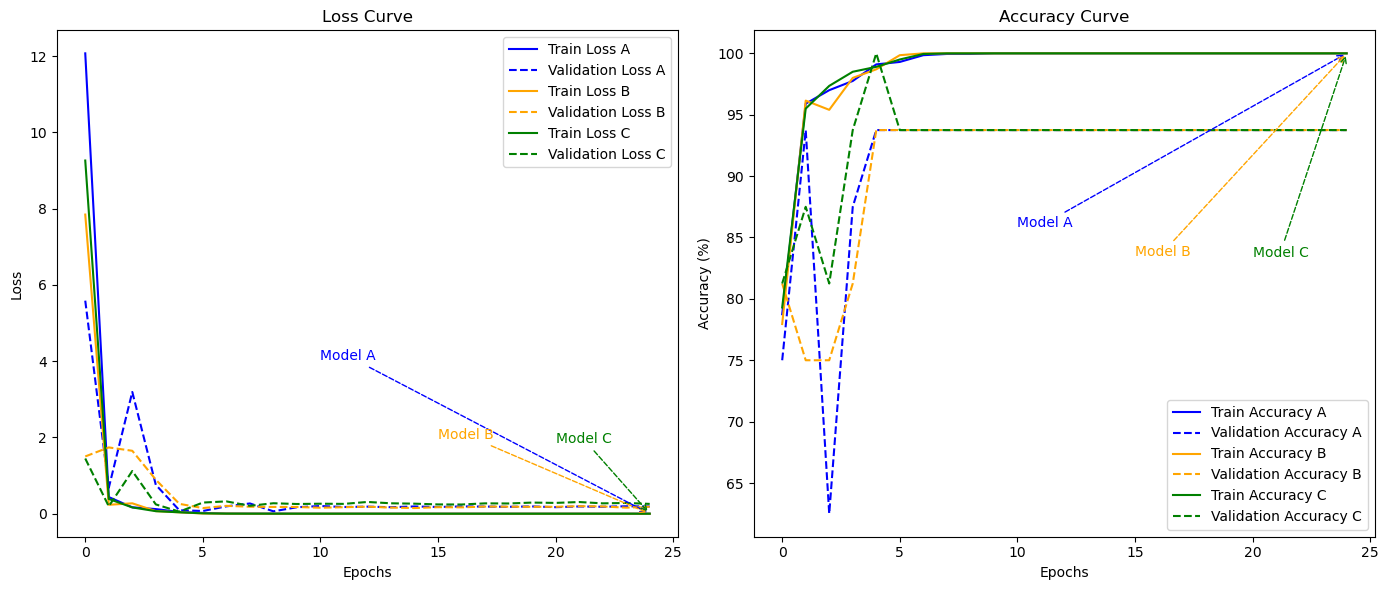

In [73]:
import matplotlib.pyplot as plt

# Assume each model's training and validation losses and accuracies are stored as tuples (model_A, model_B, model_C).
# We will extract these values to plot separately.

# Extract train and validation losses, and accuracies for each model
train_losses_A, train_losses_B, train_losses_C = zip(*train_losses)
val_losses_A, val_losses_B, val_losses_C = zip(*val_losses)
train_accuracies_A, train_accuracies_B, train_accuracies_C = zip(*train_accuracies)
val_accuracies_A, val_accuracies_B, val_accuracies_C = zip(*val_accuracies)

plt.figure(figsize=(14, 6))

# Plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(train_losses_A, label='Train Loss A', color='blue')
plt.plot(val_losses_A, label='Validation Loss A', linestyle='--', color='blue')
plt.plot(train_losses_B, label='Train Loss B', color='orange')
plt.plot(val_losses_B, label='Validation Loss B', linestyle='--', color='orange')
plt.plot(train_losses_C, label='Train Loss C', color='green')
plt.plot(val_losses_C, label='Validation Loss C', linestyle='--', color='green')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Add floating annotations with dashed line connectors for Loss Curve
plt.annotate('Model A', xy=(len(train_losses_A)-1, train_losses_A[-1]), 
             xytext=(len(train_losses_A)*2/5, min(train_losses_A) + (max(train_losses_A) - min(train_losses_A)) / 3),
             arrowprops=dict(arrowstyle='->', linestyle='--', color='blue'), color='blue')
plt.annotate('Model B', xy=(len(train_losses_B)-1, train_losses_B[-1]), 
             xytext=(len(train_losses_B)*3/5, min(train_losses_B) + (max(train_losses_B) - min(train_losses_B)) / 4),
             arrowprops=dict(arrowstyle='->', linestyle='--', color='orange'), color='orange')
plt.annotate('Model C', xy=(len(train_losses_C)-1, train_losses_C[-1]), 
             xytext=(len(train_losses_C)*4/5, min(train_losses_C) + (max(train_losses_C) - min(train_losses_C)) / 5),
             arrowprops=dict(arrowstyle='->', linestyle='--', color='green'), color='green')

# Plot Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies_A, label='Train Accuracy A', color='blue')
plt.plot(val_accuracies_A, label='Validation Accuracy A', linestyle='--', color='blue')
plt.plot(train_accuracies_B, label='Train Accuracy B', color='orange')
plt.plot(val_accuracies_B, label='Validation Accuracy B', linestyle='--', color='orange')
plt.plot(train_accuracies_C, label='Train Accuracy C', color='green')
plt.plot(val_accuracies_C, label='Validation Accuracy C', linestyle='--', color='green')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

# Add floating annotations with dashed line connectors for Accuracy Curve
plt.annotate('Model A', xy=(len(train_accuracies_A)-1, train_accuracies_A[-1]), 
             xytext=(len(train_accuracies_A)*2/5, min(train_accuracies_A) + (max(train_accuracies_A) - min(train_accuracies_A)) / 3),
             arrowprops=dict(arrowstyle='->', linestyle='--', color='blue'), color='blue')
plt.annotate('Model B', xy=(len(train_accuracies_B)-1, train_accuracies_B[-1]), 
             xytext=(len(train_accuracies_B)*3/5, min(train_accuracies_B) + (max(train_accuracies_B) - min(train_accuracies_B)) / 4),
             arrowprops=dict(arrowstyle='->', linestyle='--', color='orange'), color='orange')
plt.annotate('Model C', xy=(len(train_accuracies_C)-1, train_accuracies_C[-1]), 
             xytext=(len(train_accuracies_C)*4/5, min(train_accuracies_C) + (max(train_accuracies_C) - min(train_accuracies_C)) / 5),
             arrowprops=dict(arrowstyle='->', linestyle='--', color='green'), color='green')

# Display the plot
plt.tight_layout()
plt.show()


# Evaluate

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as data
import matplotlib.pyplot as plt

# Paths to the saved models for each model
model_paths = {
    'Model A': 'best_model_A.pth',
    'Model B': 'best_model_B.pth',
    'Model C': 'best_model_C.pth'
}

# Dummy evaluation function (replace with actual evaluation logic)
def evaluate(model, device, model_path, test_loader):
    # Load the saved model
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    model.eval()  # Set the model to evaluation mode
    
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    criterion = nn.CrossEntropyLoss()
    
    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
    
    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct_predictions / total_predictions
    return avg_test_loss, accuracy

# Assuming your model is defined elsewhere and loaded
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 128 * 128, 64)  # Adjusted input size after pooling
        self.fc2 = nn.Linear(64, 2)  # Output 2 classes (change as needed)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)  # Flatten except for batch dimension
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Assuming `device` and `test_loader` are already defined
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dictionaries to store results for each model
test_losses = {}
test_accuracies = {}

# Evaluate each model
for model_name, model_path in model_paths.items():
    model = SimpleCNN()  # Instantiate the model for each evaluation
    avg_test_loss, avg_test_acc = evaluate(model, device, model_path, test_loader)
    test_losses[model_name] = avg_test_loss
    test_accuracies[model_name] = avg_test_acc
    print(f"{model_name} - Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.2f}%")

# Plotting the comparison chart
model_names = list(test_losses.keys())
loss_values = list(test_losses.values())
accuracy_values = list(test_accuracies.values())

plt.figure(figsize=(12, 5))

# Bar chart for test loss
plt.subplot(1, 2, 1)
plt.bar(model_names, loss_values, color=['blue', 'orange', 'green'])
plt.title('Test Loss Comparison')
plt.ylabel('Average Test Loss')

# Bar chart for test accuracy
plt.subplot(1, 2, 2)
plt.bar(model_names, accuracy_values, color=['blue', 'orange', 'green'])
plt.title('Test Accuracy Comparison')
plt.ylabel('Average Test Accuracy (%)')

plt.tight_layout()
plt.show()
